In [21]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import mysql.connector
import json
from collections import Counter
import os
from dowhy import CausalModel
import re
from dotenv import load_dotenv
load_dotenv()
from dowhy import CausalModel
import dowhy.datasets
import warnings

# FutureWarning を無視
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
# DB接続処理
# MySQLに接続
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="foodb"
)

In [23]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

In [24]:
# Generate some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000)

   treatment        age  severity  outcome
0          1  48.983027  7.002662        0
1          1  50.192794  6.194425        0
2          1  68.495912  3.369449        0
3          1  47.858333  8.602428        0
4          0  45.009834  5.430481        0


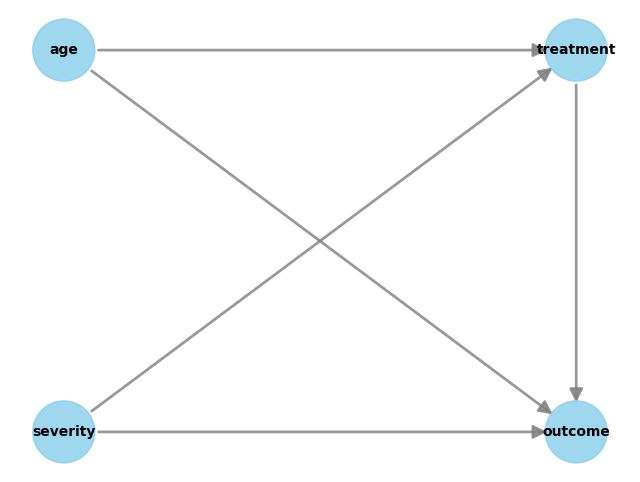

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[outcome|severity,age])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,severity,age,U) = P(outcome|treatment,severity,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Estimated Causal Effect: 0.001


In [29]:
# 仮説: 新薬Aを服用することで、病気が治る確率が高くなる（因果効果がある）。
# 手法: ランダム化試験（RCT）データまたは観測データを用い、傾向スコアマッチングを使用して因果効果を推定。
# 結果: 新薬Aを服用することで、治癒率が10%向上する。

# サンプルデータ生成
np.random.seed(0)
data = pd.DataFrame({
    "treatment": np.random.binomial(1, 0.5, 1000),
    "age": np.random.normal(50, 10, 1000),
    "severity": np.random.normal(5, 2, 1000),
    "outcome": np.nan
})
data["outcome"] = (
    0.3 * data["treatment"] +
    -0.01 * data["age"] +
    -0.2 * data["severity"] +
    np.random.normal(0, 0.1, 1000)
)
data["outcome"] = (data["outcome"] > 0).astype(int)

print(data[["treatment", "age", "severity", "outcome"]].head())

# 因果モデルの定義
model = CausalModel(
    data=data,
    treatment="treatment",
    outcome="outcome",
    common_causes=["age", "severity"]
)

# 因果グラフを視覚化
model.view_model()

# 因果効果を識別
identified_estimand = model.identify_effect()
print(identified_estimand)

# 傾向スコアマッチングを使用して因果効果を推定
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)
print(f"Estimated Causal Effect: {estimate.value}")


NameError: name 'causal_graph' is not defined

In [26]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm

# Let's generate some "normal" data we assume we're given from our problem domain:
X = np.random.normal(loc=0, scale=1, size=1000)
Y = 2 * X + np.random.normal(loc=0, scale=1, size=1000)
Z = 3 * Y + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(dict(X=X, Y=Y, Z=Z))
                    
print(data)

# Step 1: Model our system:
causal_model = gcm.StructuralCausalModel(nx.DiGraph([('X', 'Y'), ('Y', 'Z')]))
gcm.auto.assign_causal_mechanisms(causal_model, data)

# Step 2: Train our causal model with the data from above:
gcm.fit(causal_model, data)

# Step 3: Perform a causal analysis. For instance, root cause analysis, where we observe
anomalous_sample = pd.DataFrame(dict(X=[0.1], Y=[6.2], Z=[19]))  # Here, Y is the root cause.
print(anomalous_sample)

# ... and would like to answer the question:
# "Which node is the root cause of the anomaly in Z?":
anomaly_attribution = gcm.attribute_anomalies(causal_model, "Z", anomalous_sample)
print(anomaly_attribution)

            X         Y          Z
0    0.412598  1.900800   7.459738
1    0.526392  1.436187   5.002156
2    0.877924  0.288851   2.332033
3    1.103774  1.942766   5.648560
4   -0.210208 -1.452494  -3.113724
..        ...       ...        ...
995  1.018373  1.700096   6.571299
996  0.049685  0.941318   3.491012
997 -1.601849 -2.660325  -7.955237
998 -1.818411 -4.599809 -14.720567
999  1.771657  1.942358   5.289650

[1000 rows x 3 columns]


Fitting causal mechanism of node Z: 100%|██████████| 3/3 [00:00<00:00, 588.48it/s]


     X    Y   Z
0  0.1  6.2  19


Evaluating set functions...: 100%|██████████| 8/8 [00:00<00:00, 10679.32it/s]


{'X': array([-1.16717442]), 'Y': array([6.77049629]), 'Z': array([0.26314619])}
